<a href="https://colab.research.google.com/github/rabya321/ML/blob/main/trajectory_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import io



In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from google.colab import files
uploaded = files.upload()

print("Merged file saved as 'merged_final.csv'")



Using device: cuda


Saving merged.csv to merged.csv
Merged file saved as 'merged_final.csv'


In [9]:
# Loading CSV file
df = pd.read_csv('merged.csv')

dt = 1 / 50  # 50Hz
df['delta_x_v'] = df['ins_vel_hor_x'] * dt
df['delta_y_v'] = df['ins_vel_hor_y'] * dt
print("Deltas calculated.")

seq_len = 75

# Input and target columns
input_columns = ['SW_pos_obd', 'brake_pressure_obd', 'LatAcc_obd', 'speedo_obd',
                 'VelFR_obd', 'VelFL_obd', 'VelRR_obd', 'VelRL_obd', 'Yawrate_obd', 'ins_yaw']
target_columns = ['ins_vel_hor_x', 'ins_vel_hor_y', 'delta_x_v', 'delta_y_v']

# Split dataset
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))
test_size = len(df) - train_size - val_size

train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
test_data = df[train_size + val_size:]

# Scaling inputs and targets
input_scaler = StandardScaler().fit(train_data[input_columns].values)
target_scaler = StandardScaler().fit(train_data[target_columns].values)
print("Data split and scaled.")

# Dataset class
class SingleStepDataset(Dataset):
    def __init__(self, data, input_columns, target_columns, seq_len, input_scaler, target_scaler):
        self.seq_len = seq_len
        inputs = data[input_columns].values
        targets = data[target_columns].values
        self.inputs = input_scaler.transform(inputs)
        self.targets = target_scaler.transform(targets)

    def __len__(self):
        return len(self.inputs) - self.seq_len

    def __getitem__(self, idx):
        x = self.inputs[idx : idx + self.seq_len]
        y = self.targets[idx + self.seq_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_dataset = SingleStepDataset(train_data, input_columns, target_columns, seq_len, input_scaler, target_scaler)
val_dataset = SingleStepDataset(val_data, input_columns, target_columns, seq_len, input_scaler, target_scaler)
test_dataset = SingleStepDataset(test_data, input_columns, target_columns, seq_len, input_scaler, target_scaler)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Data loaded into DataLoaders.")

# LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Hyperparameters
input_size = len(input_columns)
hidden_size = 64
num_layers = 3
output_size = len(target_columns)
dropout = 0.2
learning_rate = 0.0005
weight_decay = 1e-5
epochs = 50
patience = 10

# Initialize model, loss, optimizer
model = LSTMRegressor(input_size, hidden_size, num_layers, output_size, dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
best_val_loss = np.inf
early_stopping_counter = 0
print("Model initialized.")

Deltas calculated.
Data split and scaled.
Data loaded into DataLoaders.
Model initialized.


In [10]:
# Training loop
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            predictions = model(x_val)
            loss = criterion(predictions, y_val)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model2.pth')
        print(f"Best model saved at epoch {epoch+1}.")
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break



Epoch 1/50 - Train Loss: 0.0732, Val Loss: 0.0092
Best model saved at epoch 1.
Epoch 2/50 - Train Loss: 0.0612, Val Loss: 0.0085
Best model saved at epoch 2.
Epoch 3/50 - Train Loss: 0.0566, Val Loss: 0.0091
Epoch 4/50 - Train Loss: 0.0517, Val Loss: 0.0098
Epoch 5/50 - Train Loss: 0.0485, Val Loss: 0.0077
Best model saved at epoch 5.
Epoch 6/50 - Train Loss: 0.0448, Val Loss: 0.0100
Epoch 7/50 - Train Loss: 0.0408, Val Loss: 0.0083
Epoch 8/50 - Train Loss: 0.0393, Val Loss: 0.0161
Epoch 9/50 - Train Loss: 0.0359, Val Loss: 0.0076
Best model saved at epoch 9.
Epoch 10/50 - Train Loss: 0.0353, Val Loss: 0.0080
Epoch 11/50 - Train Loss: 0.0331, Val Loss: 0.0055
Best model saved at epoch 11.
Epoch 12/50 - Train Loss: 0.0332, Val Loss: 0.0054
Best model saved at epoch 12.
Epoch 13/50 - Train Loss: 0.0320, Val Loss: 0.0081
Epoch 14/50 - Train Loss: 0.0294, Val Loss: 0.0069
Epoch 15/50 - Train Loss: 0.0283, Val Loss: 0.0079
Epoch 16/50 - Train Loss: 0.0271, Val Loss: 0.0079
Epoch 17/50 - Tra

In [11]:
# Load best model
model.load_state_dict(torch.load('best_model2.pth', map_location=device))
model.eval()
print("Best model loaded.")

# Predictions
preds, targets = [], []
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        pred = model(x_test).cpu().numpy()
        preds.append(pred)
        targets.append(y_test.numpy())
preds = np.concatenate(preds, axis=0)
targets = np.concatenate(targets, axis=0)
preds_unscaled = target_scaler.inverse_transform(preds)
targets_unscaled = target_scaler.inverse_transform(targets)



Best model loaded.



--- ins_vel_hor_x ---
MSE : 0.0214
RMSE: 0.1464
MAE : 0.0778
R²  : 0.9978


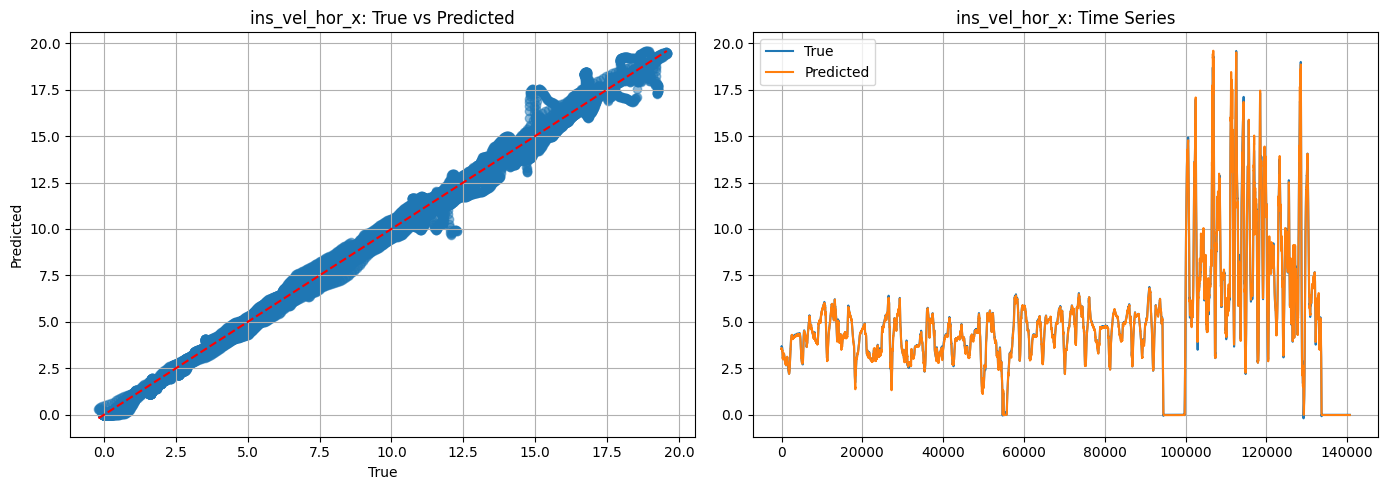


--- ins_vel_hor_y ---
MSE : 0.0014
RMSE: 0.0373
MAE : 0.0131
R²  : 0.9007


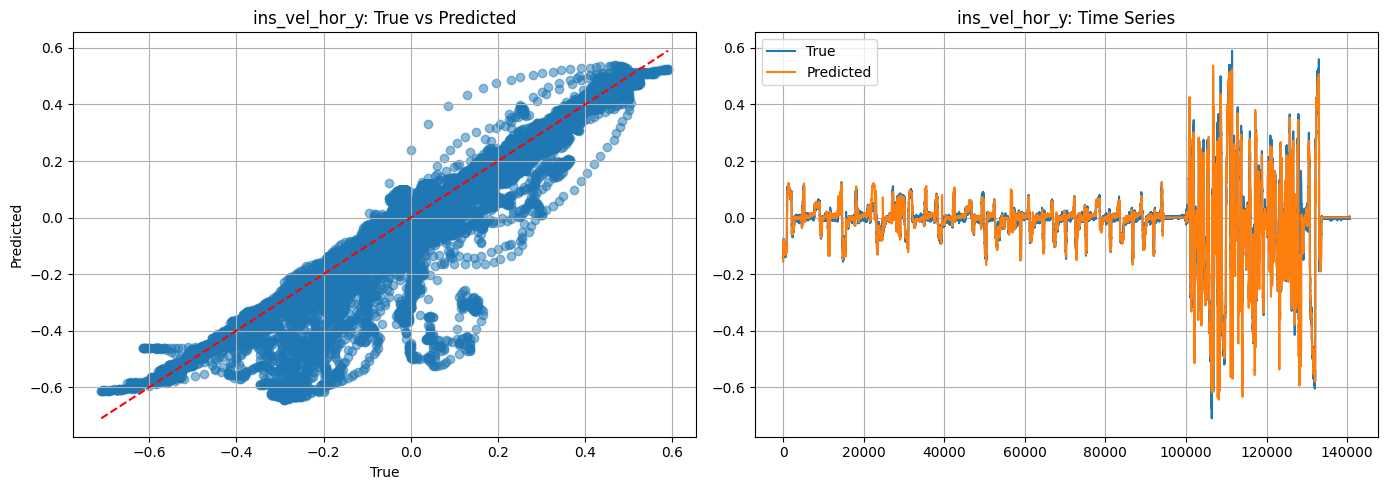


--- delta_x_v ---
MSE : 0.0000
RMSE: 0.0029
MAE : 0.0016
R²  : 0.9978


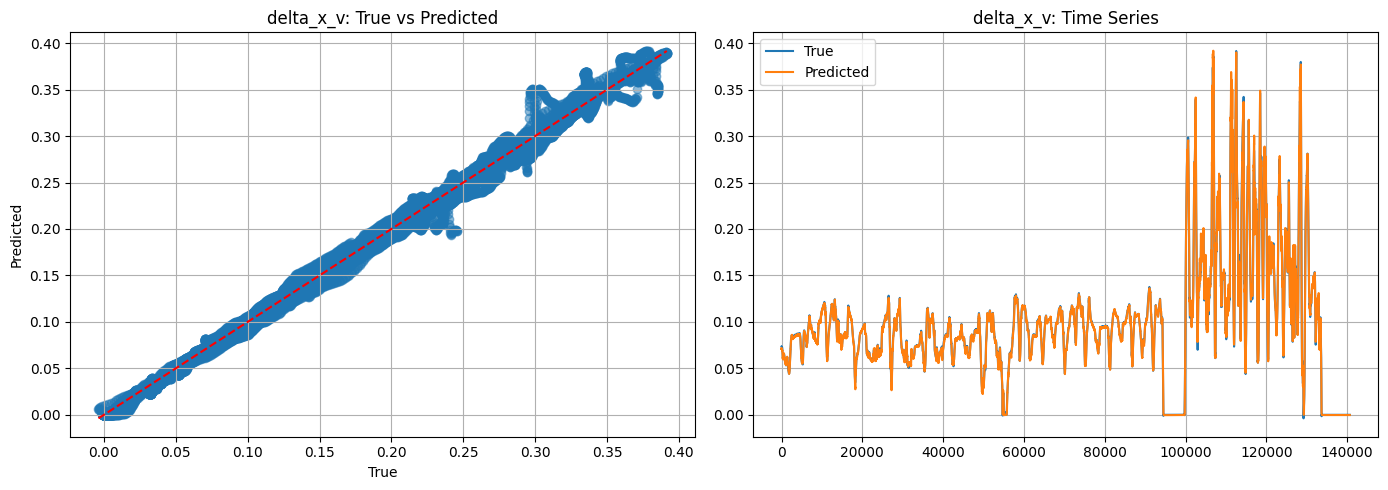


--- delta_y_v ---
MSE : 0.0000
RMSE: 0.0007
MAE : 0.0003
R²  : 0.9007


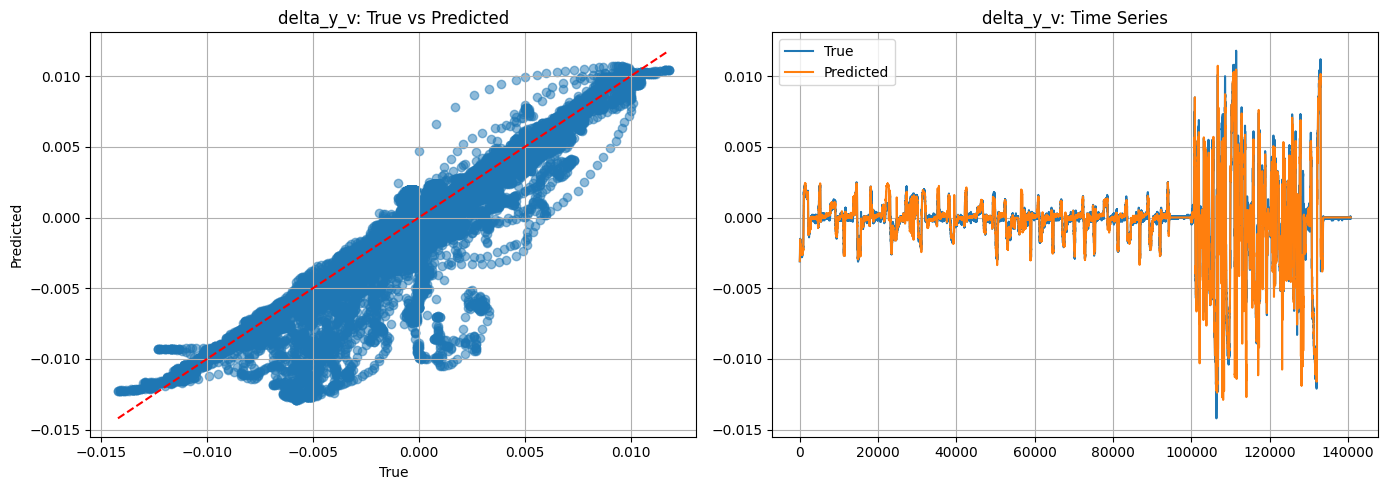

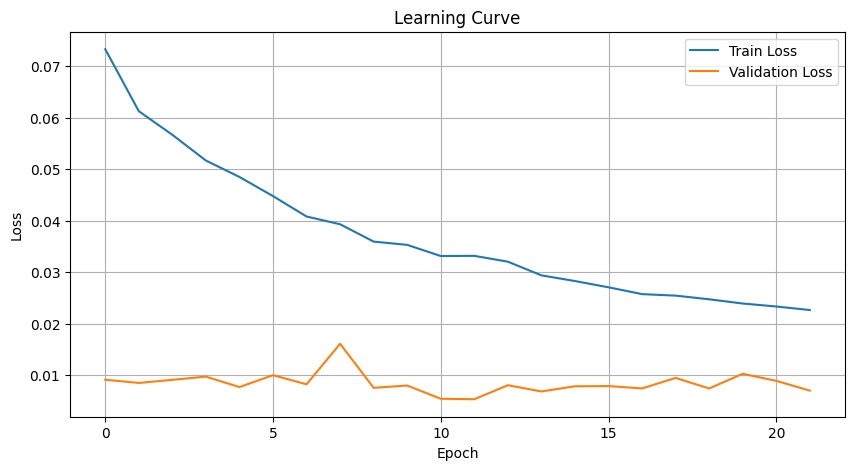

In [12]:
# Metrics and plots
metrics = {}
for i, name in enumerate(target_columns):
    y_true = targets_unscaled[:, i]
    y_pred = preds_unscaled[:, i]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    metrics[name] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

    print(f"\n--- {name} ---")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    axes[0].set_title(f'{name}: True vs Predicted')
    axes[0].set_xlabel('True')
    axes[0].set_ylabel('Predicted')
    axes[0].grid(True)

    axes[1].plot(y_true, label='True')
    axes[1].plot(y_pred, label='Predicted')
    axes[1].set_title(f'{name}: Time Series')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()



<Figure size 1000x800 with 0 Axes>

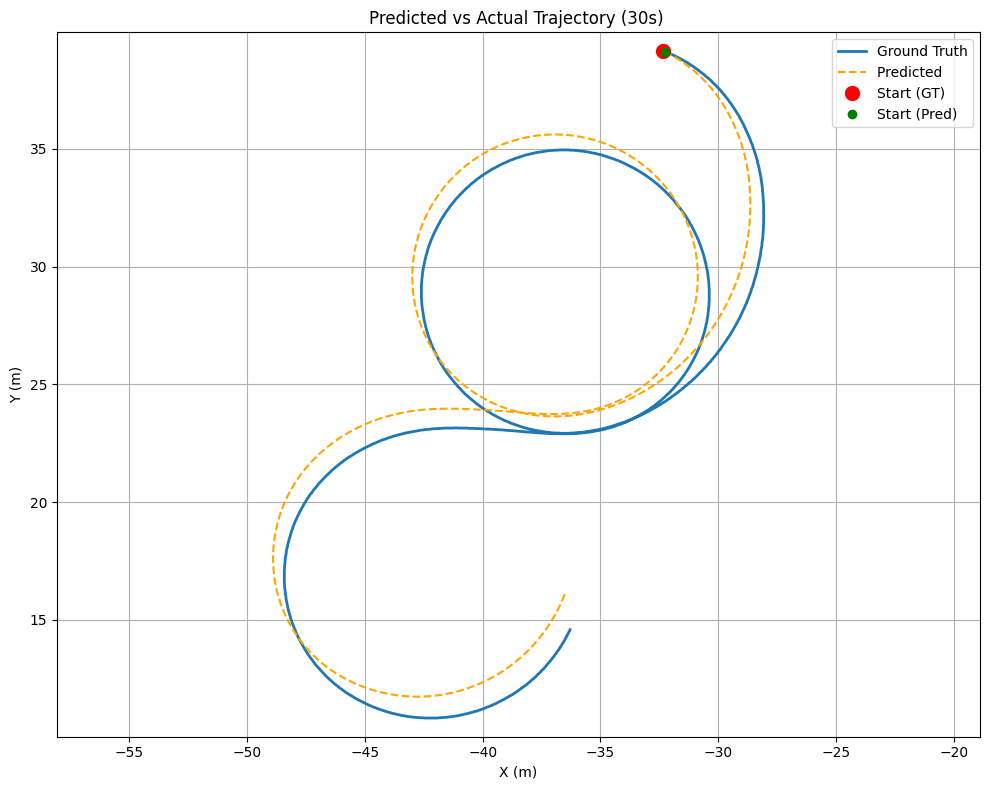

<Figure size 640x480 with 0 Axes>

In [16]:
# Trajectory reconstruction for the first 30 seconds of the test set
num_timesteps30 = 30 * 50

yaw_segment30 = df['ins_yaw'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps30]
yaw_segment30 = -np.deg2rad(yaw_segment30) # Ensure the yaw is in radians and inversed

pred_dx_v_segment30 = preds_unscaled[:num_timesteps30, 2]
pred_dy_v_segment30 = preds_unscaled[:num_timesteps30, 3]

# Rotate deltas to the fixed frame for the segment
delta_x_f_segment30 = pred_dx_v_segment30 * np.cos(yaw_segment30) - pred_dy_v_segment30 * np.sin(yaw_segment30)
delta_y_f_segment30 = pred_dx_v_segment30 * np.sin(yaw_segment30) + pred_dy_v_segment30 * np.cos(yaw_segment30) # Corrected sin angle

# Get the starting point of the test set
start_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size]
start_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size]

# Calculate predicted trajectory for the segment
pred_pos_x_segment30 = np.cumsum(delta_x_f_segment30) + start_x
pred_pos_y_segment30 = np.cumsum(delta_y_f_segment30) + start_y

# Get ground truth trajectory for the segment
gt_pos_x_segment30 = df['ins_pos_rel_x'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps30]
gt_pos_y_segment30 = df['ins_pos_rel_y'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps30]

plt.figure(figsize=(10, 8))


plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x_segment30, gt_pos_y_segment30, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x_segment30, pred_pos_y_segment30, label='Predicted ', linestyle='--', color='orange')
plt.plot(gt_pos_x_segment30[0], gt_pos_y_segment30[0], 'ro', markersize=10, label='Start (GT)')
plt.plot(pred_pos_x_segment30[0], pred_pos_y_segment30[0], 'go', markersize=6, label='Start (Pred)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory (30s) ')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
plt.savefig("Trajectory 30s")

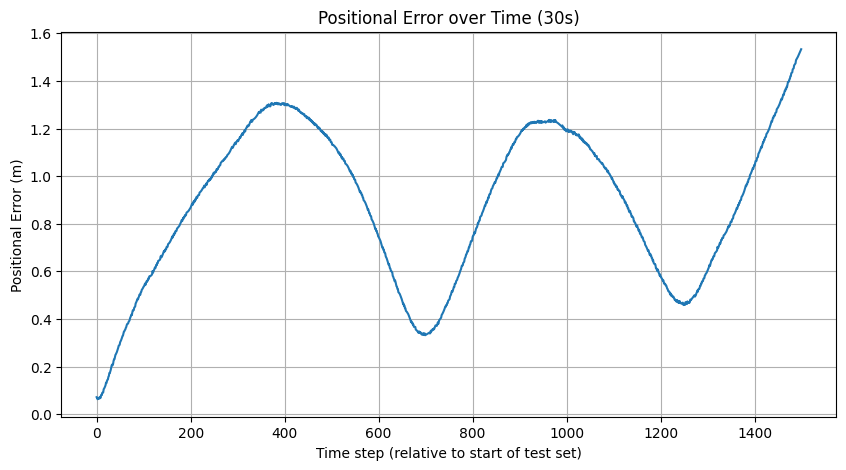

Minimum positional error: 0.063 meters
time: 0.04 seconds (0.00 minutes)
Maximum positional error: 1.533 meters
time: 29.98 seconds (0.50 minutes)


In [19]:
# Calculate error
error_30 = np.sqrt((pred_pos_x_segment30 - gt_pos_x_segment30)**2 + (pred_pos_y_segment30 - gt_pos_y_segment30)**2)

# Plot error over time
plt.figure(figsize=(10, 5))
plt.plot(error_30)
plt.xlabel('Time step (relative to start of test set)')
plt.ylabel('Positional Error (m)')
plt.title('Positional Error over Time (30s)')
plt.grid(True)
plt.show()

# Find the minimum positional error and its time step
min_error = np.min(error_30)
min_error_index = np.argmin(error_30)

print(f"Minimum positional error: {min_error:.3f} meters")

# Convert to time in seconds or minutes (50 Hz sampling rate)
min_error_time_seconds = min_error_index / 50
min_error_time_minutes = min_error_time_seconds / 60
print(f"time: {min_error_time_seconds:.2f} seconds ({min_error_time_minutes:.2f} minutes)")

# Find the maximum positional error and its time step
max_error = np.max(error_30)
max_error_index = np.argmax(error_30)

print(f"Maximum positional error: {max_error:.3f} meters")

# Convert to time in seconds or minutes (50 Hz sampling rate)
max_error_time_seconds = max_error_index / 50

max_error_time_minutes = max_error_time_seconds / 60
print(f"time: {max_error_time_seconds:.2f} seconds ({max_error_time_minutes:.2f} minutes)")


<Figure size 1000x800 with 0 Axes>

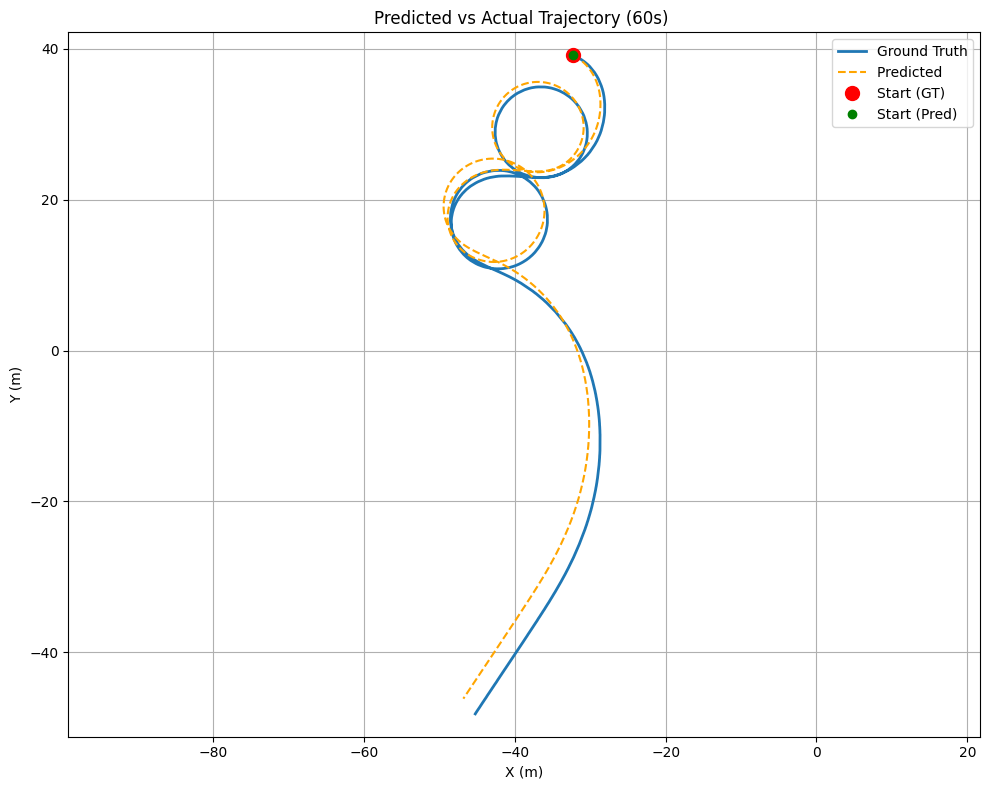

<Figure size 640x480 with 0 Axes>

In [21]:
# Trajectory reconstruction for the first 60 seconds of the test set
num_timesteps60 = 60 * 50

yaw_segment60 = df['ins_yaw'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps60]
yaw_segment60 = -np.deg2rad(yaw_segment60) # Ensure the yaw is in radians and inversed

pred_dx_v_segment60 = preds_unscaled[:num_timesteps60, 2]
pred_dy_v_segment60 = preds_unscaled[:num_timesteps60, 3]

# Rotate deltas to the fixed frame for the segment
delta_x_f_segment60 = pred_dx_v_segment60 * np.cos(yaw_segment60) - pred_dy_v_segment60 * np.sin(yaw_segment60)
delta_y_f_segment60 = pred_dx_v_segment60 * np.sin(yaw_segment60) + pred_dy_v_segment60 * np.cos(yaw_segment60)

# Get the starting point of the test set
start_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size]
start_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size]

# Calculate predicted trajectory for the segment
pred_pos_x_segment60 = np.cumsum(delta_x_f_segment60) + start_x
pred_pos_y_segment60 = np.cumsum(delta_y_f_segment60) + start_y

# Get ground truth trajectory for the segment
gt_pos_x_segment60 = df['ins_pos_rel_x'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps60]
gt_pos_y_segment60 = df['ins_pos_rel_y'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps60]

plt.figure(figsize=(10, 8))


plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x_segment60, gt_pos_y_segment60, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x_segment60, pred_pos_y_segment60, label='Predicted ', linestyle='--', color='orange')
plt.plot(gt_pos_x_segment60[0], gt_pos_y_segment60[0], 'ro', markersize=10, label='Start (GT)')
plt.plot(pred_pos_x_segment60[0], pred_pos_y_segment60[0], 'go', markersize=6, label='Start (Pred)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory (60s) ')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
plt.savefig("Trajectory 60s")

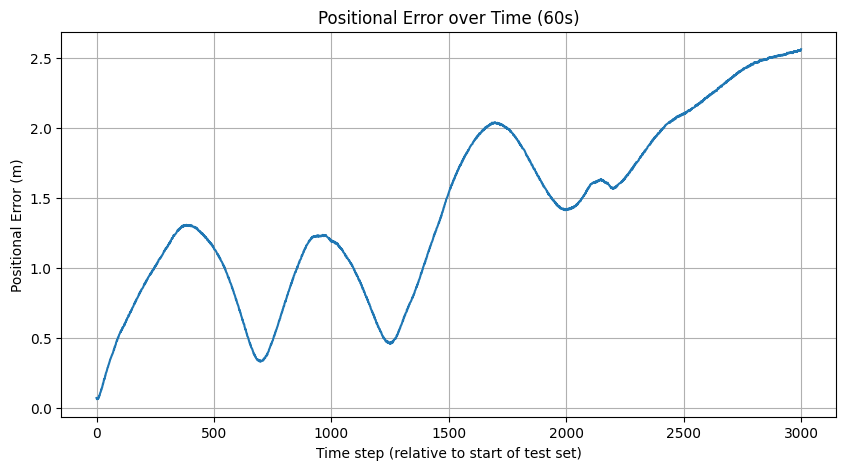

Minimum positional error: 0.063 meters
time: 0.04 seconds (0.00 minutes)
Maximum positional error: 2.562 meters
time: 59.98 seconds (1.00 minutes)


In [22]:
# Calculate error
error_60 = np.sqrt((pred_pos_x_segment60 - gt_pos_x_segment60)**2 + (pred_pos_y_segment60 - gt_pos_y_segment60)**2)

# Plot error over time
plt.figure(figsize=(10, 5))
plt.plot(error_60)
plt.xlabel('Time step (relative to start of test set)')
plt.ylabel('Positional Error (m)')
plt.title('Positional Error over Time (60s)')
plt.grid(True)
plt.show()

# Find the minimum positional error and its time step
min_error = np.min(error_60)
min_error_index = np.argmin(error_60)

print(f"Minimum positional error: {min_error:.3f} meters")

# Convert to time in seconds or minutes (50 Hz sampling rate)
min_error_time_seconds = min_error_index / 50
min_error_time_minutes = min_error_time_seconds / 60
print(f"time: {min_error_time_seconds:.2f} seconds ({min_error_time_minutes:.2f} minutes)")

# Find the maximum positional error and its time step
max_error = np.max(error_60)
max_error_index = np.argmax(error_60)

print(f"Maximum positional error: {max_error:.3f} meters")

# Convert to time in seconds or minutes (50 Hz sampling rate)
max_error_time_seconds = max_error_index / 50

max_error_time_minutes = max_error_time_seconds / 60
print(f"time: {max_error_time_seconds:.2f} seconds ({max_error_time_minutes:.2f} minutes)")


<Figure size 1000x800 with 0 Axes>

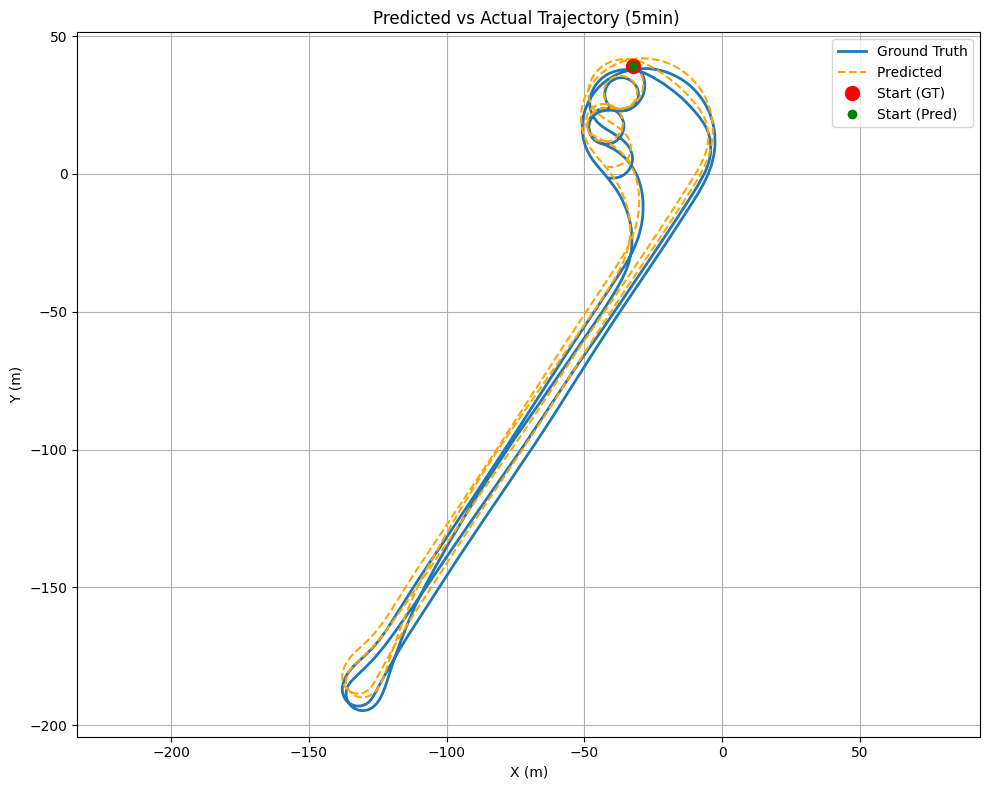

<Figure size 640x480 with 0 Axes>

In [23]:
# Trajectory reconstruction for the first 300 seconds of the test set
num_timesteps300 = 300 * 50

yaw_segment300 = df['ins_yaw'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps300]
yaw_segment300 = -np.deg2rad(yaw_segment300) # Ensure the yaw is in radians and inversed

pred_dx_v_segment300 = preds_unscaled[:num_timesteps300, 2]
pred_dy_v_segment300 = preds_unscaled[:num_timesteps300, 3]

# Rotate deltas to the fixed frame for the segment
delta_x_f_segment300 = pred_dx_v_segment300 * np.cos(yaw_segment300) - pred_dy_v_segment300 * np.sin(yaw_segment300)
delta_y_f_segment300 = pred_dx_v_segment300 * np.sin(yaw_segment300) + pred_dy_v_segment300 * np.cos(yaw_segment300)

# Get the starting point of the test set
start_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size]
start_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size]

# Calculate predicted trajectory for the segment
pred_pos_x_segment300 = np.cumsum(delta_x_f_segment300) + start_x
pred_pos_y_segment300 = np.cumsum(delta_y_f_segment300) + start_y

# Get ground truth trajectory for the segment
gt_pos_x_segment300 = df['ins_pos_rel_x'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps300]
gt_pos_y_segment300 = df['ins_pos_rel_y'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps300]

plt.figure(figsize=(10, 8))


plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x_segment300, gt_pos_y_segment300, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x_segment300, pred_pos_y_segment300, label='Predicted ', linestyle='--', color='orange')
plt.plot(gt_pos_x_segment300[0], gt_pos_y_segment300[0], 'ro', markersize=10, label='Start (GT)')
plt.plot(pred_pos_x_segment300[0], pred_pos_y_segment300[0], 'go', markersize=6, label='Start (Pred)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory (5min) ')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
plt.savefig("Trajectory 300s")

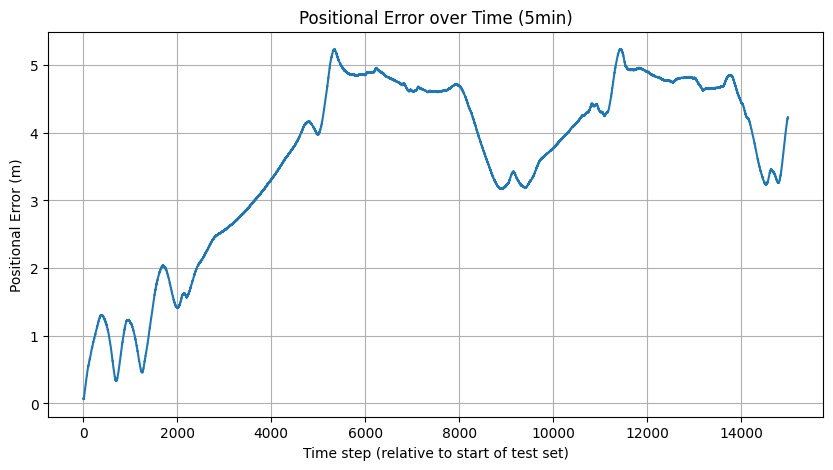

Minimum positional error: 0.063 meters
time: 0.04 seconds (0.00 minutes)
Maximum positional error: 5.235 meters
time: 228.82 seconds (3.81 minutes)


In [24]:
# Calculate error
error_300 = np.sqrt((pred_pos_x_segment300 - gt_pos_x_segment300)**2 + (pred_pos_y_segment300 - gt_pos_y_segment300)**2)

# Plot error over time
plt.figure(figsize=(10, 5))
plt.plot(error_300)
plt.xlabel('Time step (relative to start of test set)')
plt.ylabel('Positional Error (m)')
plt.title('Positional Error over Time (5min)')
plt.grid(True)
plt.show()

# Find the minimum positional error and its time step
min_error = np.min(error_300)
min_error_index = np.argmin(error_300)

print(f"Minimum positional error: {min_error:.3f} meters")

# Convert to time in seconds or minutes (50 Hz sampling rate)
min_error_time_seconds = min_error_index / 50
min_error_time_minutes = min_error_time_seconds / 60
print(f"time: {min_error_time_seconds:.2f} seconds ({min_error_time_minutes:.2f} minutes)")

# Find the maximum positional error and its time step
max_error = np.max(error_300)
max_error_index = np.argmax(error_300)

print(f"Maximum positional error: {max_error:.3f} meters")

# Convert to time in seconds or minutes (50 Hz sampling rate)
max_error_time_seconds = max_error_index / 50

max_error_time_minutes = max_error_time_seconds / 60
print(f"time: {max_error_time_seconds:.2f} seconds ({max_error_time_minutes:.2f} minutes)")


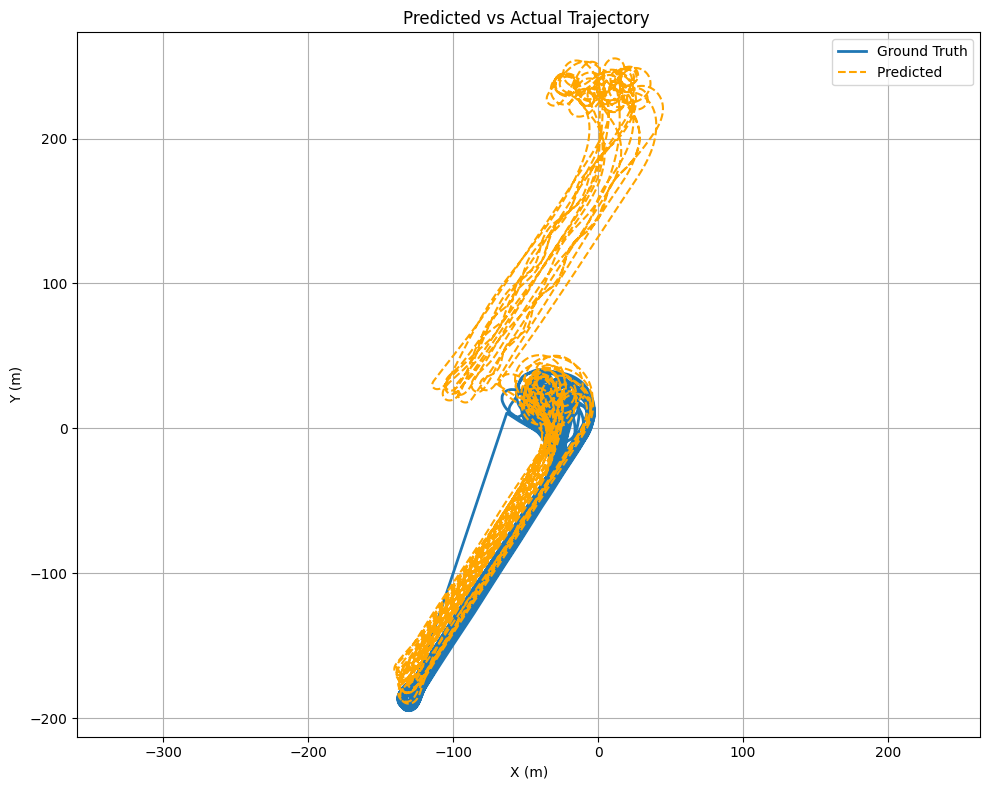

<Figure size 640x480 with 0 Axes>

In [25]:
# Trajectory reconstruction
yaw = df['ins_yaw'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + len(preds_unscaled)]
yaw = -np.deg2rad(yaw)

pred_dx_v = preds_unscaled[:, 2]
pred_dy_v = preds_unscaled[:, 3]

#converting to global frame
delta_x_f = pred_dx_v * np.cos(yaw) - pred_dy_v * np.sin(yaw)
delta_y_f = pred_dx_v * np.sin(yaw) + pred_dy_v * np.cos(yaw)

#initial position
start_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size]
start_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size]

# Cumulative sum to get the trajectory
pred_pos_x = np.cumsum(delta_x_f) + start_x
pred_pos_y = np.cumsum(delta_y_f) + start_y


gt_pos_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + len(preds_unscaled)]
gt_pos_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + len(preds_unscaled)]

plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x, gt_pos_y, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x, pred_pos_y, label='Predicted ', linestyle='--', color='orange')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory ')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
plt.savefig("Trajectory_full")

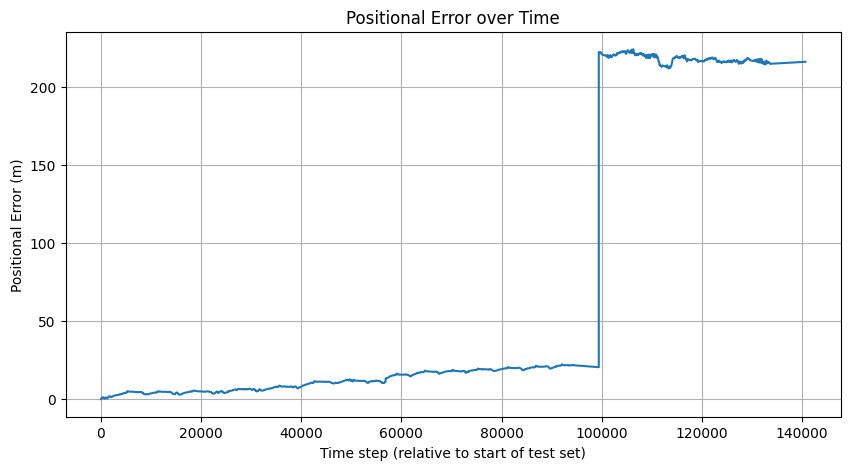

Maximum positional error: 223.925 meters
time: 2126.06 seconds (35.43 minutes)


In [27]:
# positional error (euclidean distance) for the full trajectory
errors = np.sqrt((gt_pos_x - pred_pos_x)**2 + (gt_pos_y - pred_pos_y)**2)

# Plot error over time
plt.figure(figsize=(10, 5))
plt.plot(errors)
plt.xlabel('Time step (relative to start of test set)')
plt.ylabel('Positional Error (m)')
plt.title('Positional Error over Time')
plt.grid(True)
plt.show()

# Find the maximum positional error and its time step
max_error = np.max(errors)
max_error_index = np.argmax(errors)

print(f"Maximum positional error: {max_error:.3f} meters")

# Convert to time in seconds or minutes (50 Hz sampling rate)
max_error_time_seconds = max_error_index / 50

max_error_time_minutes = max_error_time_seconds / 60
print(f"time: {max_error_time_seconds:.2f} seconds ({max_error_time_minutes:.2f} minutes)")


